# Table of contents

[Regression](#regression)


In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.1.1
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Data generator

#### Poisson

In [645]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
lmbd_0, lmbd_1 = 20, 20
trial_length, num_trials = 2, 500
spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials)

#### Hawkes process

In [659]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
    'type': 'triangle', 'mu': [20., 20.], 'alpha': [[0., 0], [0.0, 0.0]], 'beta': [[1.0, 0.05], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda stable: [20. 20.]
Gamma
[[0. 0.]
 [0. 0.]]
100%|█████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.76it/s]


#### Amarasingham + coupling filter.

In [784]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 50, 'num_trials': 1000, 'baseline': 10, 'sigma': 0.04, 'random_seed': 2,
    'type': 'square', 'alpha': [[0., 0.], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda_max (proposal): 365.38
lambda stable: [91.34 91.34]
100%|███████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.57it/s]


#### Amarasingham non-repeated trials + coupling filter

In [3]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 50, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6,
    'type': 'square', 'alpha': [[0., 3], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|███████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.80it/s]


#### Check data statistics.

layers 3, nodes 2, trials 1000
meanFR [35.33  34.954]	meanISI [36.734 36.334]


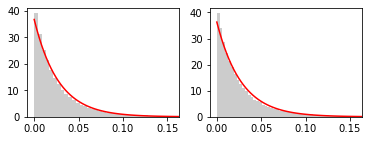

layers 3, nodes 2, trials 1000


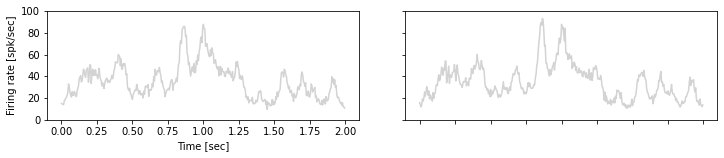

In [785]:
generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=1)
_=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
# generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0,1], trial_ids=[0], plot_window=[0, 0.5], ylim=[None, None])

# Nuisance variable correction.

#### No filter.

In [987]:
model_par = {'filter_type': 'none',
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 200, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x[:50], spike_times_y[:50], trial_window, model_par, verbose=True)

X.shape (3535, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
 36%|█████████████████████▉                                      | 73/200 [00:00<00:00, 1463.85it/s]
num itr 73 [[-9186.24151933]] 9.55071234820526e-07
beta [22.25082047  0.36682107]
gradient [ 4.76301878e-06 -4.98558711e-05]


#### Discrete optimization verification.

In [975]:
dt = 0.001
beta=jittertool.bivariate_discrete_time_coupling_filter_regression(
    spike_times_x[:50], spike_times_y[:50], trial_window, dt, model_par_hat, mean_norm=False, num_itrs=10000)
model_par_hat['beta'] = beta

X.shape (100000, 2) beta.shape (2, 1)
sum spikes, lambda  3535.0 3529.138341588263
itr0	nll: -9192.2	beta: [22.25082017  0.36843765]
itr1000	nll: -9192.3	beta: [22.21840598  0.37129852]
itr2000	nll: -9192.3	beta: [22.1893755   0.37191023]
itr3000	nll: -9192.3	beta: [22.16341602  0.37245745]
itr4000	nll: -9192.3	beta: [22.14020575  0.3729469 ]
itr5000	nll: -9192.3	beta: [22.11945598  0.37338461]
itr6000	nll: -9192.3	beta: [22.10090784  0.37377599]
itr7000	nll: -9192.3	beta: [22.08432929  0.3741259 ]
itr8000	nll: -9192.3	beta: [22.06951246  0.3744387 ]
itr9000	nll: -9192.3	beta: [22.05627113  0.3747183 ]


#### Analytical solution for L2 loss WITHOUT coupling effect.

In [1007]:
dt = 0.001
beta=jittertool.analytical_L2_loss_no_coupling(
    spike_times_x[:50], spike_times_y[:50], trial_window, dt, model_par_hat)

beta: [21.85959102  0.37777678]


In [1010]:
dt = 0.001
beta=jittertool.basis_test(
    spike_times_x[:50], spike_times_y[:50], trial_window, dt, model_par_hat)

[[3677.]]
[[1.24959751e+12]]


#### Const + triangle

In [ ]:
sample_y = np.arange(0, trial_length, 0.01).reshape(1,-1)
_=jittertool.construct_regressors_triangle_kernel(spike_times_x[0], sample_y, 0.03, verbose=True)

In [896]:
jittertool = jitter.JitterTool()
# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x[:50], spike_times_y[:50], trial_window, model_par, verbose=True)

X.shape (3535, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
 73%|███████████████████████████████████████████▊                | 73/100 [00:00<00:00, 1978.18it/s]
num itr 73 [[-9186.44238418]] 9.736223595124827e-07
beta [22.26343731  0.3494823   0.42463634]
gradient [ 4.94550524e-06 -3.90149098e-05 -2.09743666e-06]


In [ ]:
file_path = project_dir + 'Output/fig/eg_amarasingham_square_filter_weak_nuisance_regression_jitterwindow120ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-6, 10], file_path=None)

# Spectrum analysis.

X.shape (40000, 2)


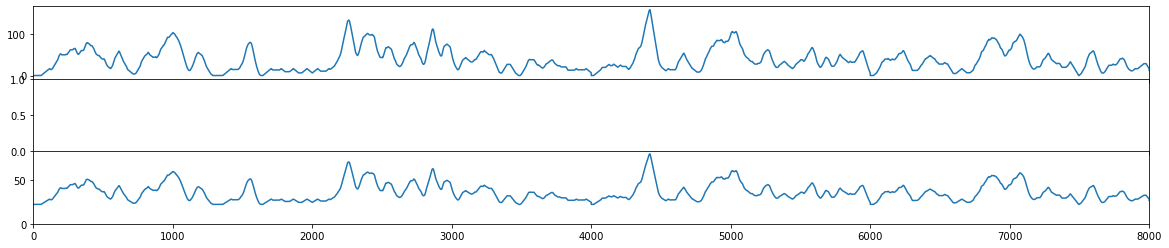

In [789]:
jittertool.plot_bivariate_continuous_time_coupling_filter_regressors(spike_times_x[:20], spike_times_y[:20], trial_window, 0.001, model_par_hat)

#### True intensity.

100%|█████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


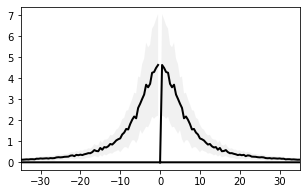

In [802]:
trial_length = 2
trial_window = [0, trial_length]
generator_par0 = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 50, 'baseline': 10, 'sigma': 0.04, 'random_seed': 7,
    'type': 'square', 'alpha': [[0., 0], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
dt = 0.001
# _=jittertool.dft_intensity(generator_par0, dt, zero_padding_length=0, xlim=35)
_=jittertool.dft_intensity(generator_par0, dt, zero_padding_length=0, mean_norm=True, num_examples=1, xlim=35)

y.shape (2000,)  spectrum.shape (2000,)


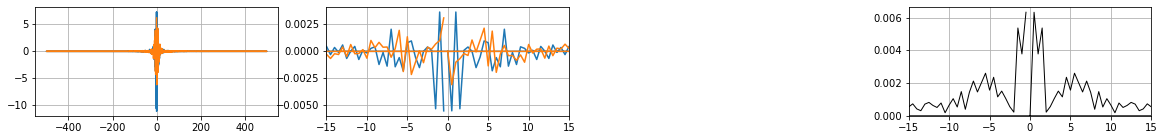

Parseval: 0.49956325563941417 (0.49956325563941395+0j)


In [857]:
dt = 0.001
_=jittertool.dft_intensity(generator_par, dt, zero_padding_length=0, mean_norm=True, num_examples=1, xlim=15)

#### Laplace window

y.shape (4000,)  spectrum.shape (4000,)


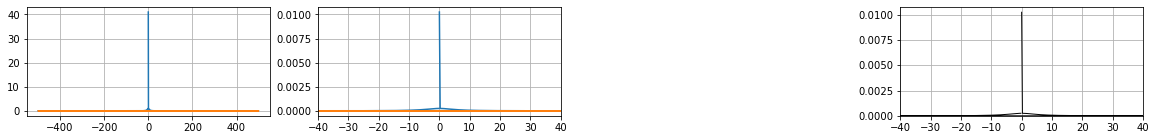

Parseval: 0.42884460059571045 (0.42884460059571045+0j)
y.shape (4000,)  spectrum.shape (4000,)


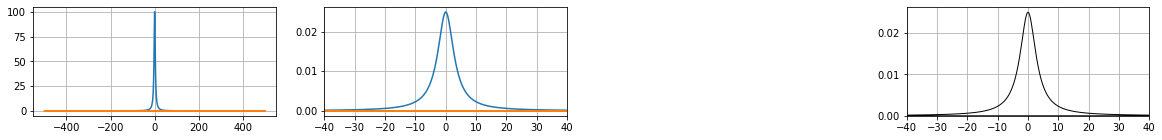

Parseval: 50.00666648889235 (50.00666648889235+0j)
y.shape (4000,)  spectrum.shape (4000,)


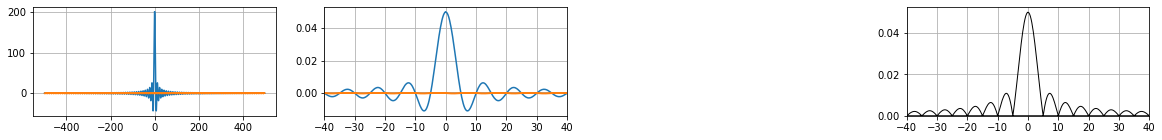

Parseval: 200.0 (200+0j)
y.shape (4000,)  spectrum.shape (4000,)


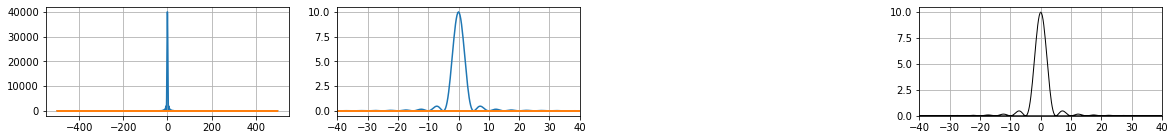

Parseval: 5333400.0 (5333400.000000002+0j)


In [783]:
trial_length = 4
trial_window = [0, trial_length]
generator_par0 = {'trial_length': trial_length, 'trial_window': trial_window, 'sigma': 0.04, 'baseline':10}
dt = 0.001
jittertool.dft_window(generator_par0, dt, xlim=40)

#### Spike trains.

y.shape (100, 2000)  spectrum.shape (100, 2000)


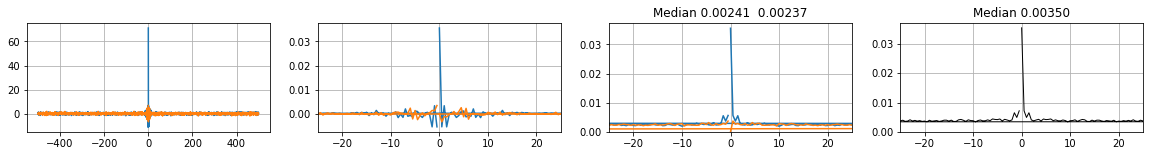

Parseval: 7405.0 (7405+0j)


In [1016]:
dt = 0.001
_=jittertool.dft_spike_times(spike_times_y[:100], trial_window, dt, zero_padding_length=0, plot_type='average', mean_norm=False, xlim=25)

y.shape (1000000,)  spectrum.shape (1000000,)


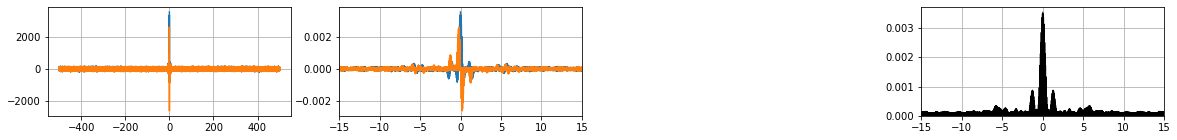

Parseval: 3677.0 (3677.0000000000023+0j)
y.shape (1000000,)  spectrum.shape (1000000,)


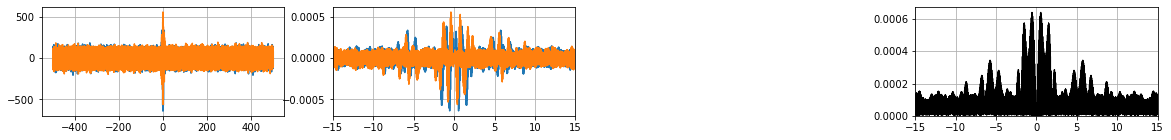

Parseval: 3550.507500000009 (3550.5075000000134+0j)
y.shape (50, 2000)  spectrum.shape (50, 2000)


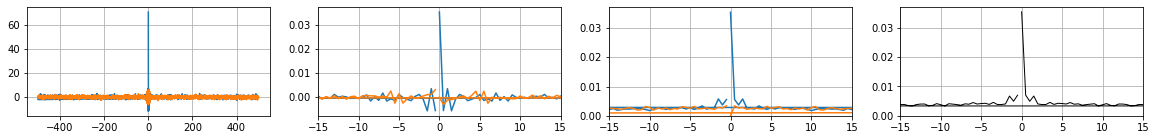

Parseval: 3677.0 (3677+0j)
y.shape (50, 2000)  spectrum.shape (50, 2000)


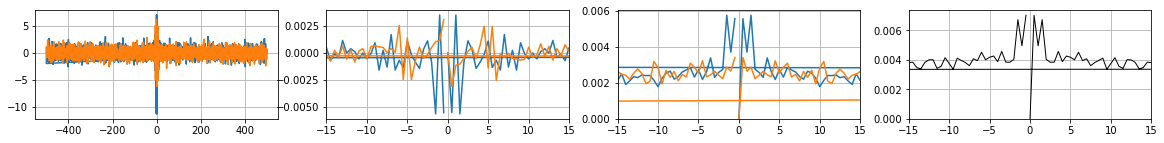

Parseval: 3550.5074999999983 (3550.5075+0j)


In [804]:
dt = 0.001
_=jittertool.dft_spike_times(spike_times_y[:50], trial_window, dt, zero_padding_length=18, plot_type='concatenate', xlim=15)
_=jittertool.dft_spike_times(spike_times_y[:50], trial_window, dt, zero_padding_length=18, plot_type='concatenate', mean_norm=True, xlim=15)
_=jittertool.dft_spike_times(spike_times_y[:50], trial_window, dt, zero_padding_length=0, plot_type='average', xlim=15)
_=jittertool.dft_spike_times(spike_times_y[:50], trial_window, dt, zero_padding_length=0, plot_type='average', mean_norm=True, xlim=15)

#### $\tilde\lambda$

X.shape (100000, 2)
y.shape (50, 2000)  spectrum.shape (50, 2000)


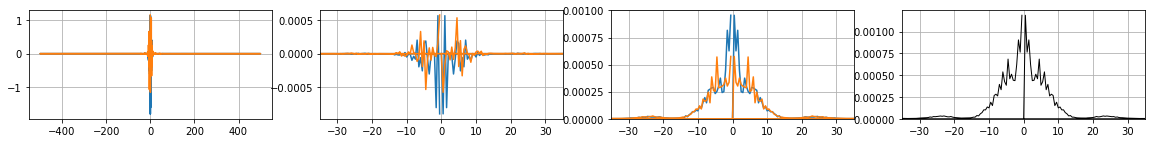

Parseval: 3.492020698172642 (3.492020698172642+0j)


In [932]:
dt = 0.001
# _=jittertool.dft_lambda(spike_times_x[:20], spike_times_y[:50], trial_window, dt, model_par_hat, zero_padding_length=0,
#                       mean_norm=True, stack_type='concatenate', xlim=25)
# _=jittertool.dft_lambda(spike_times_x[:20], spike_times_y[:50], trial_window, dt, model_par_hat, zero_padding_length=0,
#                       mean_norm=False, stack_type='average', xlim=25)
_=jittertool.dft_lambda(spike_times_x[:20], spike_times_y[:50], trial_window, dt, model_par_hat, zero_padding_length=0,
                      mean_norm=True, stack_type='average', xlim=35)

#### $\mathcal{F}\textbf{s} \to \mathcal{F}\lambda$

y.shape (200, 2000)  spectrum.shape (200, 2000)


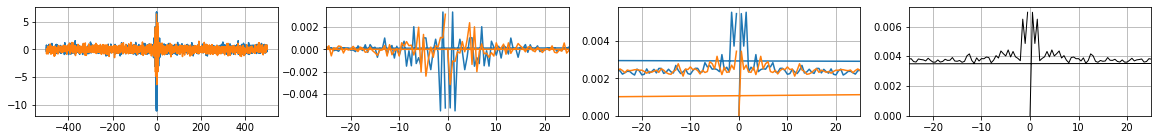

Parseval: 14257.726499999993 (14257.7265+0j)
y.shape (2000,)  spectrum.shape (2000,)


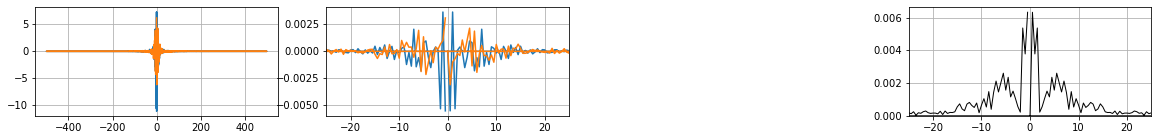

Parseval: 0.49956325563941417 (0.49956325563941395+0j)
X.shape (400000, 2)
y.shape (200, 2000)  spectrum.shape (200, 2000)


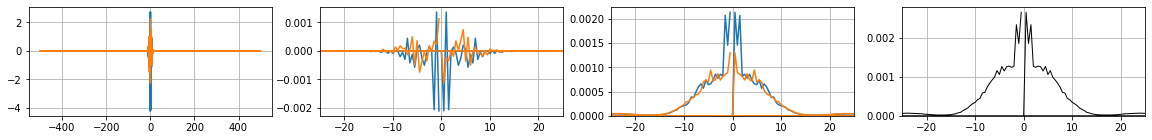

Parseval: 32.12478284745903 (32.12478284745903+0j)


In [865]:
dt = 0.001
_=jittertool.dft_spike_times(spike_times_y[:200], trial_window, dt, zero_padding_length=0, plot_type='average', mean_norm=True, xlim=25)
_=jittertool.dft_intensity(generator_par, dt, zero_padding_length=0, mean_norm=True, num_examples=1, xlim=25)
_=jittertool.dft_lambda(spike_times_x[:200], spike_times_y[:200], trial_window, dt, model_par_hat, zero_padding_length=0,
                      mean_norm=True, stack_type='average', xlim=25)

####   $\Psi(t)$

X.shape (40000, 2)
y.shape (40000,)  spectrum.shape (40000,)


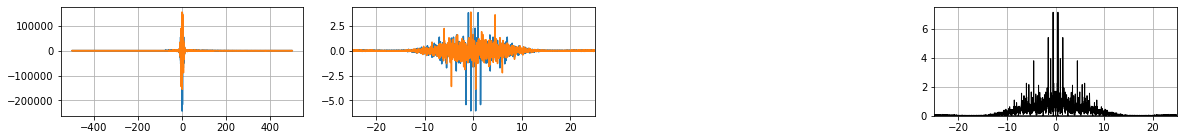

Parseval: 26461853.557933982 (26461853.557934042+0j)
X.shape (40000, 2)
y.shape (20, 2000)  spectrum.shape (20, 2000)


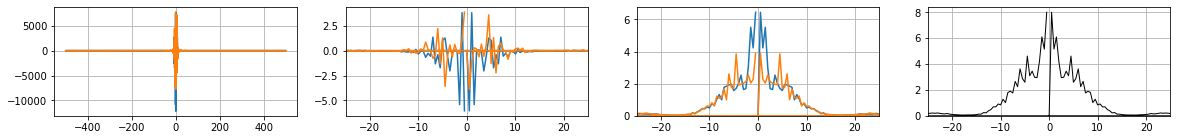

Parseval: 25403762.102186892 (25403762.102186885+0j)


In [705]:
dt = 0.001
beta_id=1
_=jittertool.dft_phi(spike_times_x[:20], spike_times_y[:20], beta_id, trial_window, dt, model_par_hat, zero_padding_length=0,
                      mean_norm=True, stack_type='concatenate', xlim=25)
_=jittertool.dft_phi(spike_times_x[:20], spike_times_y[:20], beta_id, trial_window, dt, model_par_hat, zero_padding_length=0,
                      mean_norm=True, stack_type='average', xlim=25)

#### Factor 2: $N(dt) - \tilde\lambda(t)dt$

X.shape (100000, 2)
sum spikes, lambda  3535.0 3542.460166049016
nll: -9192.2432768178
y.shape (50, 2000)  spectrum.shape (50, 2000)


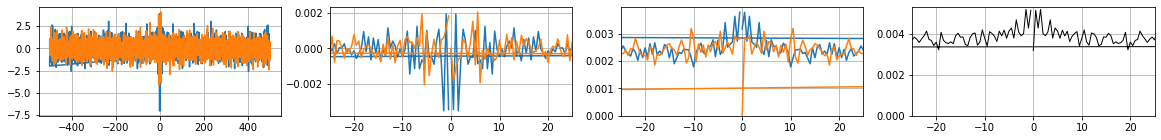

Parseval: 3542.675732317406 (3542.675732317405+0j)


In [933]:
dt = 0.001
# spectrum,_=jittertool.dft_residual(spike_times_x[:50], spike_times_y[:50], trial_window, dt, model_par_hat, zero_padding_length=0,
#         mean_norm=False, stack_type='concatenate', xlim=25)
# print(spectrum[0])
spectrum,_=jittertool.dft_residual(spike_times_x[:50], spike_times_y[:50], trial_window, dt, model_par_hat, zero_padding_length=0,
        mean_norm=False, stack_type='average', xlim=25)
# print(spectrum[:,:10])

X.shape (200000, 2)
sum spikes, lambda  7113.0 7040.12994656824
nll: -18522.32860253943
y.shape (100, 2000)  spectrum.shape (100, 2000)


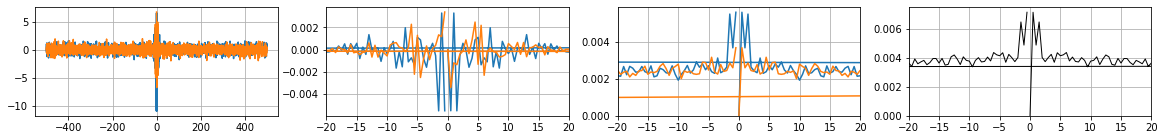

Parseval: 7148.881499999996 (7148.8815+0j)
X.shape (200000, 2)
y.shape (100, 2000)  spectrum.shape (100, 2000)


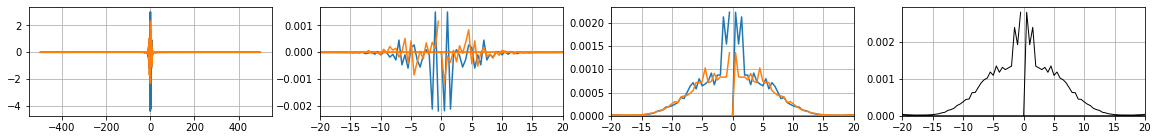

Parseval: 16.897344445839586 (16.897344445839583+0j)


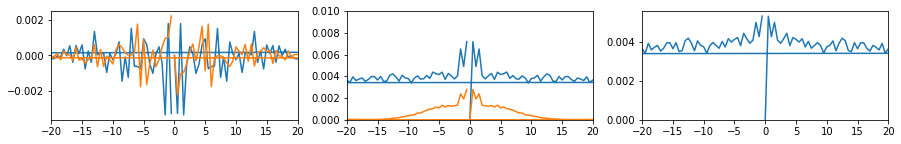

In [934]:
dt = 0.001
spectrum,_=jittertool.dft_residual(spike_times_x[:100], spike_times_y[:100], trial_window, dt, model_par_hat, zero_padding_length=0,
        mean_norm=False, stack_type='average_spectrum_diff', xlim=20, verbose=True)

#### Factor 1: $\Psi(t)/\tilde\lambda(t)$

X.shape (100000, 2)
y.shape (100000,)  spectrum.shape (100000,)


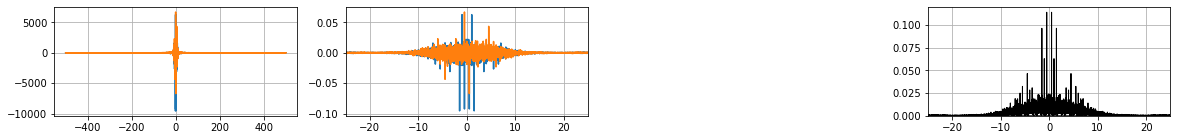

Parseval: 19020.126107759796 (19020.126107759796+0j)
X.shape (100000, 2)
y.shape (50, 2000)  spectrum.shape (50, 2000)


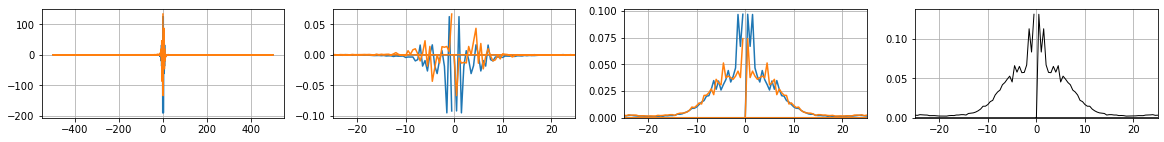

Parseval: 18419.45432507354 (18419.454325073548+0j)


In [881]:
dt = 0.001
beta_id = 1
_=jittertool.dft_phi_div_lambda(spike_times_x[:50], spike_times_y[:50], beta_id, trial_window, dt, model_par_hat, zero_padding_length=0,
                      mean_norm=True, stack_type='concatenate', xlim=25)
_=jittertool.dft_phi_div_lambda(spike_times_x[:50], spike_times_y[:50], beta_id, trial_window, dt, model_par_hat, zero_padding_length=0,
                      mean_norm=True, stack_type='average', xlim=25)

#### Derivative of log-likelihood.

X.shape (100000, 2)
y.shape (50, 2000)  spectrum.shape (50, 2000)


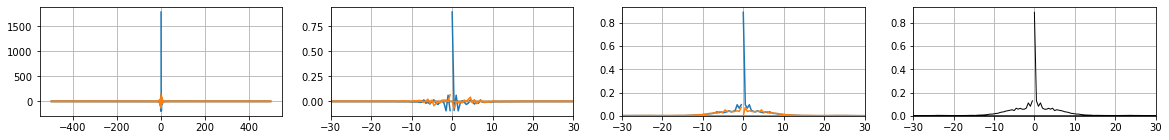

Parseval: 98576.94350422974 (98576.94350422974+0j)
X.shape (100000, 2)
sum spikes, lambda  3535.0 3539.238977652604
nll: -9192.277180395695
y.shape (50, 2000)  spectrum.shape (50, 2000)


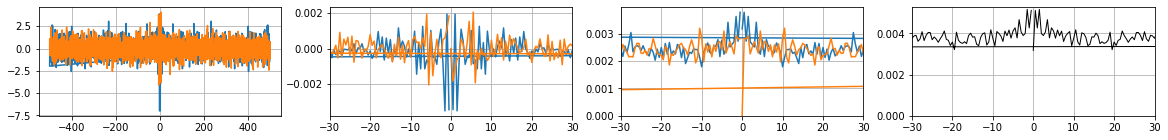

Parseval: 3542.6726327912543 (3542.6726327912534+0j)

D LL: 0.004045573350611065   F LL: (0.0040455733506387336+1.3555823130673162e-15j)
spectrum energy: (98576.94350422974+0j) (3542.6726327912534+0j)


In [942]:
dt = 0.001
beta_id = 1
# jittertool.dft_dirivative_log_likelihood(spike_times_x[:50], spike_times_y[:50], beta_id, trial_window, dt, model_par_hat, 
#         zero_padding_length=0, stack_type='concatenate', xlim=25, verbose=True)
jittertool.dft_dirivative_log_likelihood(spike_times_x[:50], spike_times_y[:50], beta_id, trial_window, dt, model_par_hat, zero_padding_length=0,
        stack_type='average', xlim=30, verbose=True)

## FFT test cases.

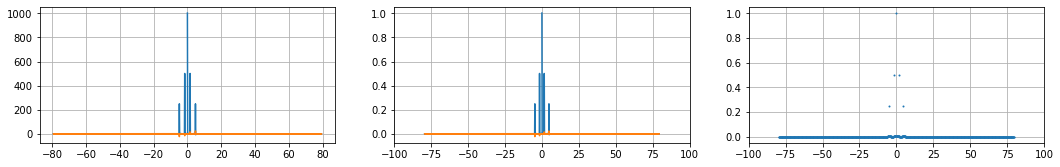

1631.25 (1632.8812500000001+0j)


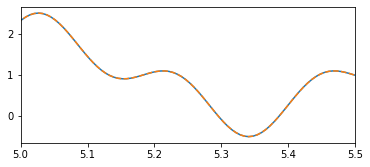

In [771]:
T = 2*np.pi
N = 10**3
dt = T / N

t = np.arange(0, T+dt, dt)
# y = np.sin(64*t) + 1
# y = np.cos(512*t) + 1
# y = np.sin(20 * t) + 0.5*np.sin(40*t) + 1
y = np.cos(10 * t) + 0.5 * np.cos(30*t) + 1
# y = np.cos(80 *2*np.pi*t) + 0.5*np.cos(10*2*np.pi*t) + 1

spectrum = np.fft.fft(y)
freq = np.fft.fftfreq(len(t), dt)

plt.figure(figsize=[18, 2.5])
plt.subplot(131)
plt.plot(freq, spectrum.real)
plt.plot(freq, spectrum.imag)
plt.grid()
plt.subplot(132)
plt.plot(freq, spectrum.real / N)
plt.plot(freq, spectrum.imag / N)
plt.xlim(-100, 100)
plt.grid()
plt.subplot(133)
plt.plot(freq, np.abs(spectrum)/N, '.', ms=2)
plt.xlim(-100, 100)
plt.grid()
plt.show()

print(y @ y, spectrum @ np.conjugate(spectrum) / N)

yhat = np.fft.ifft(spectrum)
plt.figure(figsize=[6, 2.5])
plt.plot(t, y)
plt.plot(t, yhat.real, '--')
plt.xlim(5, 5.5)
plt.show()

y.shape (40000,)		spectrum.shape (40000,)


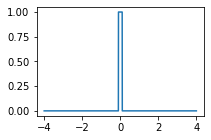

y.shape (40000,)  spectrum.shape (40000,)


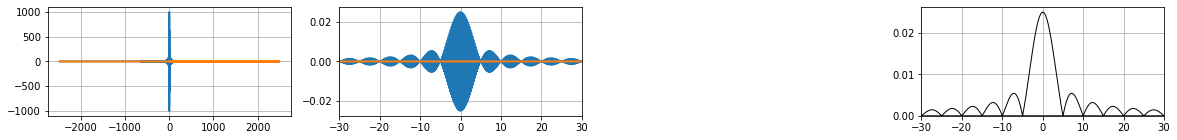

Parseval 1000.0 (1000.0000000000006+0j)
y.shape (40000,)  spectrum.shape (40000,)


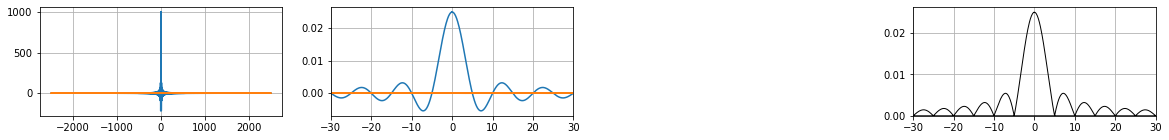

Parseval 1000.0 (1000.0000000000006+0j)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


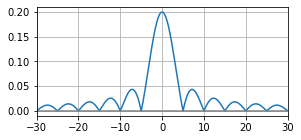

Continuous time analytical spectrum power: 0.2 0.1999594715347558


In [670]:
T = 8
dt = 0.0002
t = np.arange(-T/2, T/2, dt)
w_rect = 0.2
y = np.zeros_like(t)
y[(t > -w_rect/2) & (t < w_rect/2)] = 1

# FFT.
spectrum = np.fft.fft(y)
print(f'y.shape {y.shape}\t\t' +
      f'spectrum.shape {spectrum.shape}')
N = int(T/dt)
freq = np.fft.fftfreq(N, dt)

xlim = 30
plt.figure(figsize=[3, 2])
plt.plot(t, y)
plt.show()
_=jittertool.dft(y, dt, xlim=xlim)
_=jittertool.dft(y, dt, N//2, xlim=xlim)

# Analytical.
df = 1/T
F_max = 1/dt
F = np.arange(-F_max/2, F_max/2, df)
spectrum = np.sin(np.pi*F*w_rect) / np.pi / F  # a * sinc(x*a)
spectrum[F==0] = w_rect

plt.figure(figsize=(4.5,2))
plt.plot(F, np.abs(spectrum))
plt.xlim(-xlim, xlim)
plt.axhline(0, color='grey')
plt.grid()
plt.show()

print('Continuous time analytical spectrum power:', w_rect, spectrum @ spectrum * df)

(480, 40000) (40000,) (480,)


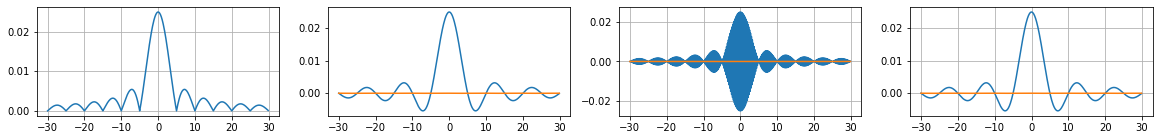

In [664]:
# DFT
frequency = np.arange(-xlim, xlim, df)
omega = frequency.reshape(-1,1) * dt
n0 = np.arange(-N/2, N/2, 1).astype(int).reshape(1,-1)
n1 = np.arange(0, N, 1).astype(int).reshape(1,-1)
integral_kernel0 = np.exp(-2j*np.pi*omega*n0)
integral_kernel1 = np.exp(-2j*np.pi*omega*n1)

y_shift = np.roll(y, N//2)
spectrum0 = integral_kernel0 @ y.T
spectrum1 = integral_kernel1 @ y.T
spectrum2 = integral_kernel1 @ y_shift.T
print(integral_kernel.shape, y.shape, spectrum0.shape)

plt.figure(figsize=[20, 2])
plt.subplot(141)
plt.plot(frequency, np.abs(spectrum0)/N)
plt.grid()
plt.subplot(142)
plt.plot(frequency, spectrum0.real/N)
plt.plot(frequency, spectrum0.imag/N)
plt.subplot(143)
plt.plot(frequency, spectrum1.real/N)
plt.plot(frequency, spectrum1.imag/N)
plt.grid()
plt.subplot(144)
plt.plot(frequency, spectrum2.real/N)
plt.plot(frequency, spectrum2.imag/N)
plt.grid()
plt.show()

#### kernel integral of hhh, or hhw.

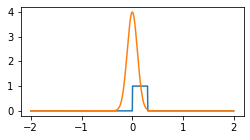

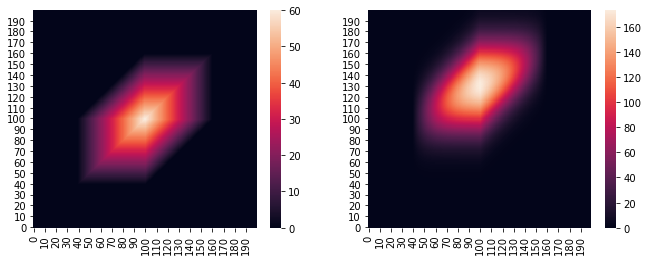

In [30]:
dt = 0.005
t = np.arange(-2, 2, dt)
length = len(t)
h = np.zeros(length)
h[(t >= 0) & (t < 0.3)] = 1
sigma = 0.1
w = 1/np.sqrt(2*np.pi)/sigma * np.exp(-t**2/2/sigma**2)

tau1s = np.arange(-0.5, 0.5, dt)
tau2s = np.arange(-0.5, 0.5, dt)
hhh = np.zeros([len(tau1s), len(tau2s)])
hhw = np.zeros([len(tau1s), len(tau2s)])

plt.figure(figsize=[4,2])
plt.plot(t, h)
plt.plot(t, w)
plt.show()

for x, tau1 in enumerate(tau1s):
    for y, tau2 in enumerate(tau1s):
        h0 = h
        h1 = np.roll(h, int(tau1/dt))
        h2 = np.roll(h, int(tau2/dt))
        w2 = np.roll(w, int(tau2/dt))
        conv = np.sum(h0*h1*h2)
        hhh[y,x] = conv
        conv = np.sum(h0*h1*w2)
        hhw[y,x] = conv

plt.figure(figsize=[11,4])
plt.subplot(121)
ax = seaborn.heatmap(hhh)
ax.invert_yaxis()
plt.subplot(122)
ax = seaborn.heatmap(hhw)
ax.invert_yaxis()

#### 1-way kernel integral

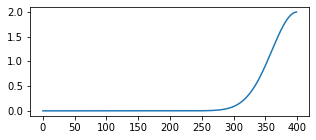

In [65]:
dt = 0.005
T = 2
t = np.arange(0, T, dt)
length = len(t)
sigma_w = 0.2

def w(t):
    w = 1/np.sqrt(2*np.pi)/sigma_w * np.exp(-t**2/2/sigma_w**2)
    return w

def dot_prod(u):
    tau1s = np.arange(-u, T-u, dt)
    ww = np.zeros(len(tau1s))
    for i, tau1 in enumerate(tau1s):
        prod = w(tau1)
        ww[i] = prod
    return ww

u = 2
ww = dot_prod(u)

plt.figure(figsize=[5,2])
plt.plot(ww)


100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 507.34it/s]


(0.0, 205.04974722881786)

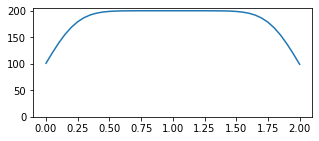

In [67]:
us = np.arange(0, 2.05, 0.05)
wws = np.zeros(len(us))

for i in tqdm(range(len(us)), ncols=100, file=sys.stdout):
    wws[i] = np.sum(dot_prod(us[i]))

plt.figure(figsize=[5, 2])
plt.plot(us, wws)
plt.ylim(0)

#### 2-way kernel shape

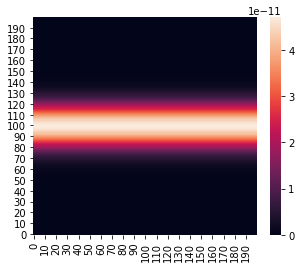

In [61]:
dt = 0.01
T = 2
t = np.arange(0, T, dt)
length = len(t)
sigma_w = 0.2
sigma_I = 0.6

def w(t):
    w = 1/np.sqrt(2*np.pi)/sigma_w * np.exp(-t**2/2/sigma_w**2)
    return w

def dot_prod(u):
    tau1s = np.arange(-u, T-u, dt)
    ww = np.zeros([len(tau1s), len(tau2s)])
    for i, tau1 in enumerate(tau1s):
        for y, tau2 in enumerate(tau1s):
            w1 = w(tau1)
            w2 = w(tau1-tau2)
            prod = w1*c1*w2
            ww[i] = prod
    return ww

u = 0
ww = dot_prod(u)

plt.figure(figsize=[5,4])
ax = seaborn.heatmap(ww)
ax.invert_yaxis()


100%|███████████████████████████████████████████████████████████████| 41/41 [00:15<00:00,  2.69it/s]


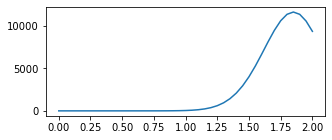

In [62]:
us = np.arange(0, 2.05, 0.05)
wwcs = np.zeros(len(us))

for i in tqdm(range(len(us)), ncols=100, file=sys.stdout):
    wwcs[i] = np.sum(dot_prod(us[i]))

plt.figure(figsize=[5, 2])
plt.plot(us, wwcs)

#### 3-way kernel shape

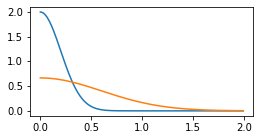

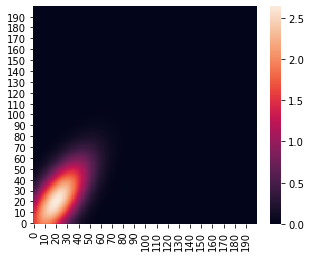

In [47]:
dt = 0.01
T = 2
t = np.arange(0, T, dt)
length = len(t)
sigma_w = 0.2
sigma_I = 0.6

def w(t):
    w = 1/np.sqrt(2*np.pi)/sigma_w * np.exp(-t**2/2/sigma_w**2)
    return w
def c(t):
    c = 1/np.sqrt(2*np.pi)/sigma_I * np.exp(-t**2/2/sigma_I**2)
    return c

def dot_prod(u):
    tau1s = np.arange(-u, T-u, dt)
    tau2s = np.arange(-u, T-u, dt)
    wwc = np.zeros([len(tau1s), len(tau2s)])

    for i, tau1 in enumerate(tau1s):
        for j, tau2 in enumerate(tau2s):
            w1 = w(tau1)
            c1 = c(tau2)
            w2 = w(tau1-tau2)
            prod = w1*c1*w2
            wwc[j,i] = prod
    return wwc

plt.figure(figsize=[4,2])
plt.plot(t, w(t))
plt.plot(t, c(t))
plt.show()

u = 0.2
wwc = dot_prod(u)

plt.figure(figsize=[5,4])
ax = seaborn.heatmap(wwc)
ax.invert_yaxis()

100%|███████████████████████████████████████████████████████████████| 41/41 [00:21<00:00,  1.86it/s]


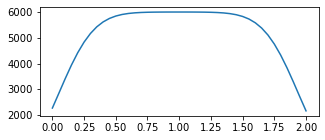

In [46]:
us = np.arange(0, 2.05, 0.05)
wwcs = np.zeros(len(us))

for i in tqdm(range(len(us)), ncols=100, file=sys.stdout):
    wwcs[i] = np.sum(dot_prod(us[i]))

plt.figure(figsize=[5, 2])
plt.plot(us, wwcs)